Como mencionado na Parte I do trabalho, e está disponível no artigo "DeepSynergy: predicting anti-cancer drug
synergy with Deep Learning", existiu um conjunto de 16 drogas que simplesmente nao foram combinadas e,como tal, a nossa ideia seria preparar um dataset para que, se possivel, no futuro e através de um modelo já treinado de ML seja previsto o valor de y.

In [1]:
from tdc.multi_pred import DrugSyn
import pandas as pd

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger

import numpy as np
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from collections import OrderedDict, Counter

from rdkit.Chem import AllChem

from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold

from rdkit import Chem
from rdkit.Chem import PandasTools, MACCSkeys
from rdkit.Chem import Draw, DataStructs
from rdkit.Chem.Draw import IPythonConsole

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


Dataset original- onde por uma simples visualização não é possível saber que existiam drogas que não tinham sido combinadas

In [2]:
data = DrugSyn(name = "OncoPolyPharmacology")
dataset=data.get_data()
dataset

Found local copy...
Loading...
Done!


Drug1_ID   Drug2_ID  Cell_Line_ID          Y  \
0         5-FU    ABT-888         A2058   7.693530   
1         5-FU    ABT-888         A2780   7.778053   
2         5-FU    ABT-888          A375  -1.198505   
3         5-FU    ABT-888          A427   2.595684   
4         5-FU    ABT-888         CAOV3  -5.139971   
...        ...        ...           ...        ...   
23047  ZOLINZA  TOPOTECAN        UACC62  10.223066   
23048  ZOLINZA  TOPOTECAN  UWB1289BRCA1  20.551627   
23049  ZOLINZA  TOPOTECAN       UWB1289  12.190316   
23050  ZOLINZA  TOPOTECAN          VCAP  23.438547   
23051  ZOLINZA  TOPOTECAN         ZR751  12.223791   

                                               Cell_Line  \
0      [5.291146039856301, 5.040386719464342, 5.29114...   
1      [5.291146039856301, 5.040386719464342, 5.29114...   
2      [5.291146039856301, 5.040386719464342, 5.29114...   
3      [5.291146039856301, 5.040386719464342, 5.29114...   
4      [5.291146039856301, 5.040386719464342, 5.29114...   
...                                                  ...   
23047  [-0.18899497244411118, -0.19839747536407973, -...   
23048  [-0.18899497244411118, -0.19839747536407973, -...   
23049  [-0.18899497244411118, -0.19839747536407973, -...   
23050  [-0.18899497244411118, -0.19839747536407973, -...   
23051  [-0.18899497244411118, -0.19839747536407973, -...   

                             Drug1  \
0          O=c1[nH]cc(F)c(=O)[nH]1   
1          O=c1[nH]cc(F)c(=O)[nH]1   
2          O=c1[nH]cc(F)c(=O)[nH]1   
3          O=c1[nH]cc(F)c(=O)[nH]1   
4          O=c1[nH]cc(F)c(=O)[nH]1   
...                            ...   
23047  O=C(CCCCCCC(=O)Nc1ccccc1)NO   
23048  O=C(CCCCCCC(=O)Nc1ccccc1)NO   
23049  O=C(CCCCCCC(=O)Nc1ccccc1)NO   
23050  O=C(CCCCCCC(=O)Nc1ccccc1)NO   
23051  O=C(CCCCCCC(=O)Nc1ccccc1)NO   

                                                   Drug2  
0                     CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
1                     CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
2                     CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
3                     CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
4                     CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
...                                                  ...  
23047  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...  
23048  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...  
23049  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...  
23050  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...  
23051  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...  

[23052 rows x 7 columns]

Este gráfico tem a mesma lógica que o observado no artigo referido anteriormente. Todavia, utilizamos uma média para os valores de Y sendo que no artigo utilizam o valor de Y de um cell line específica.

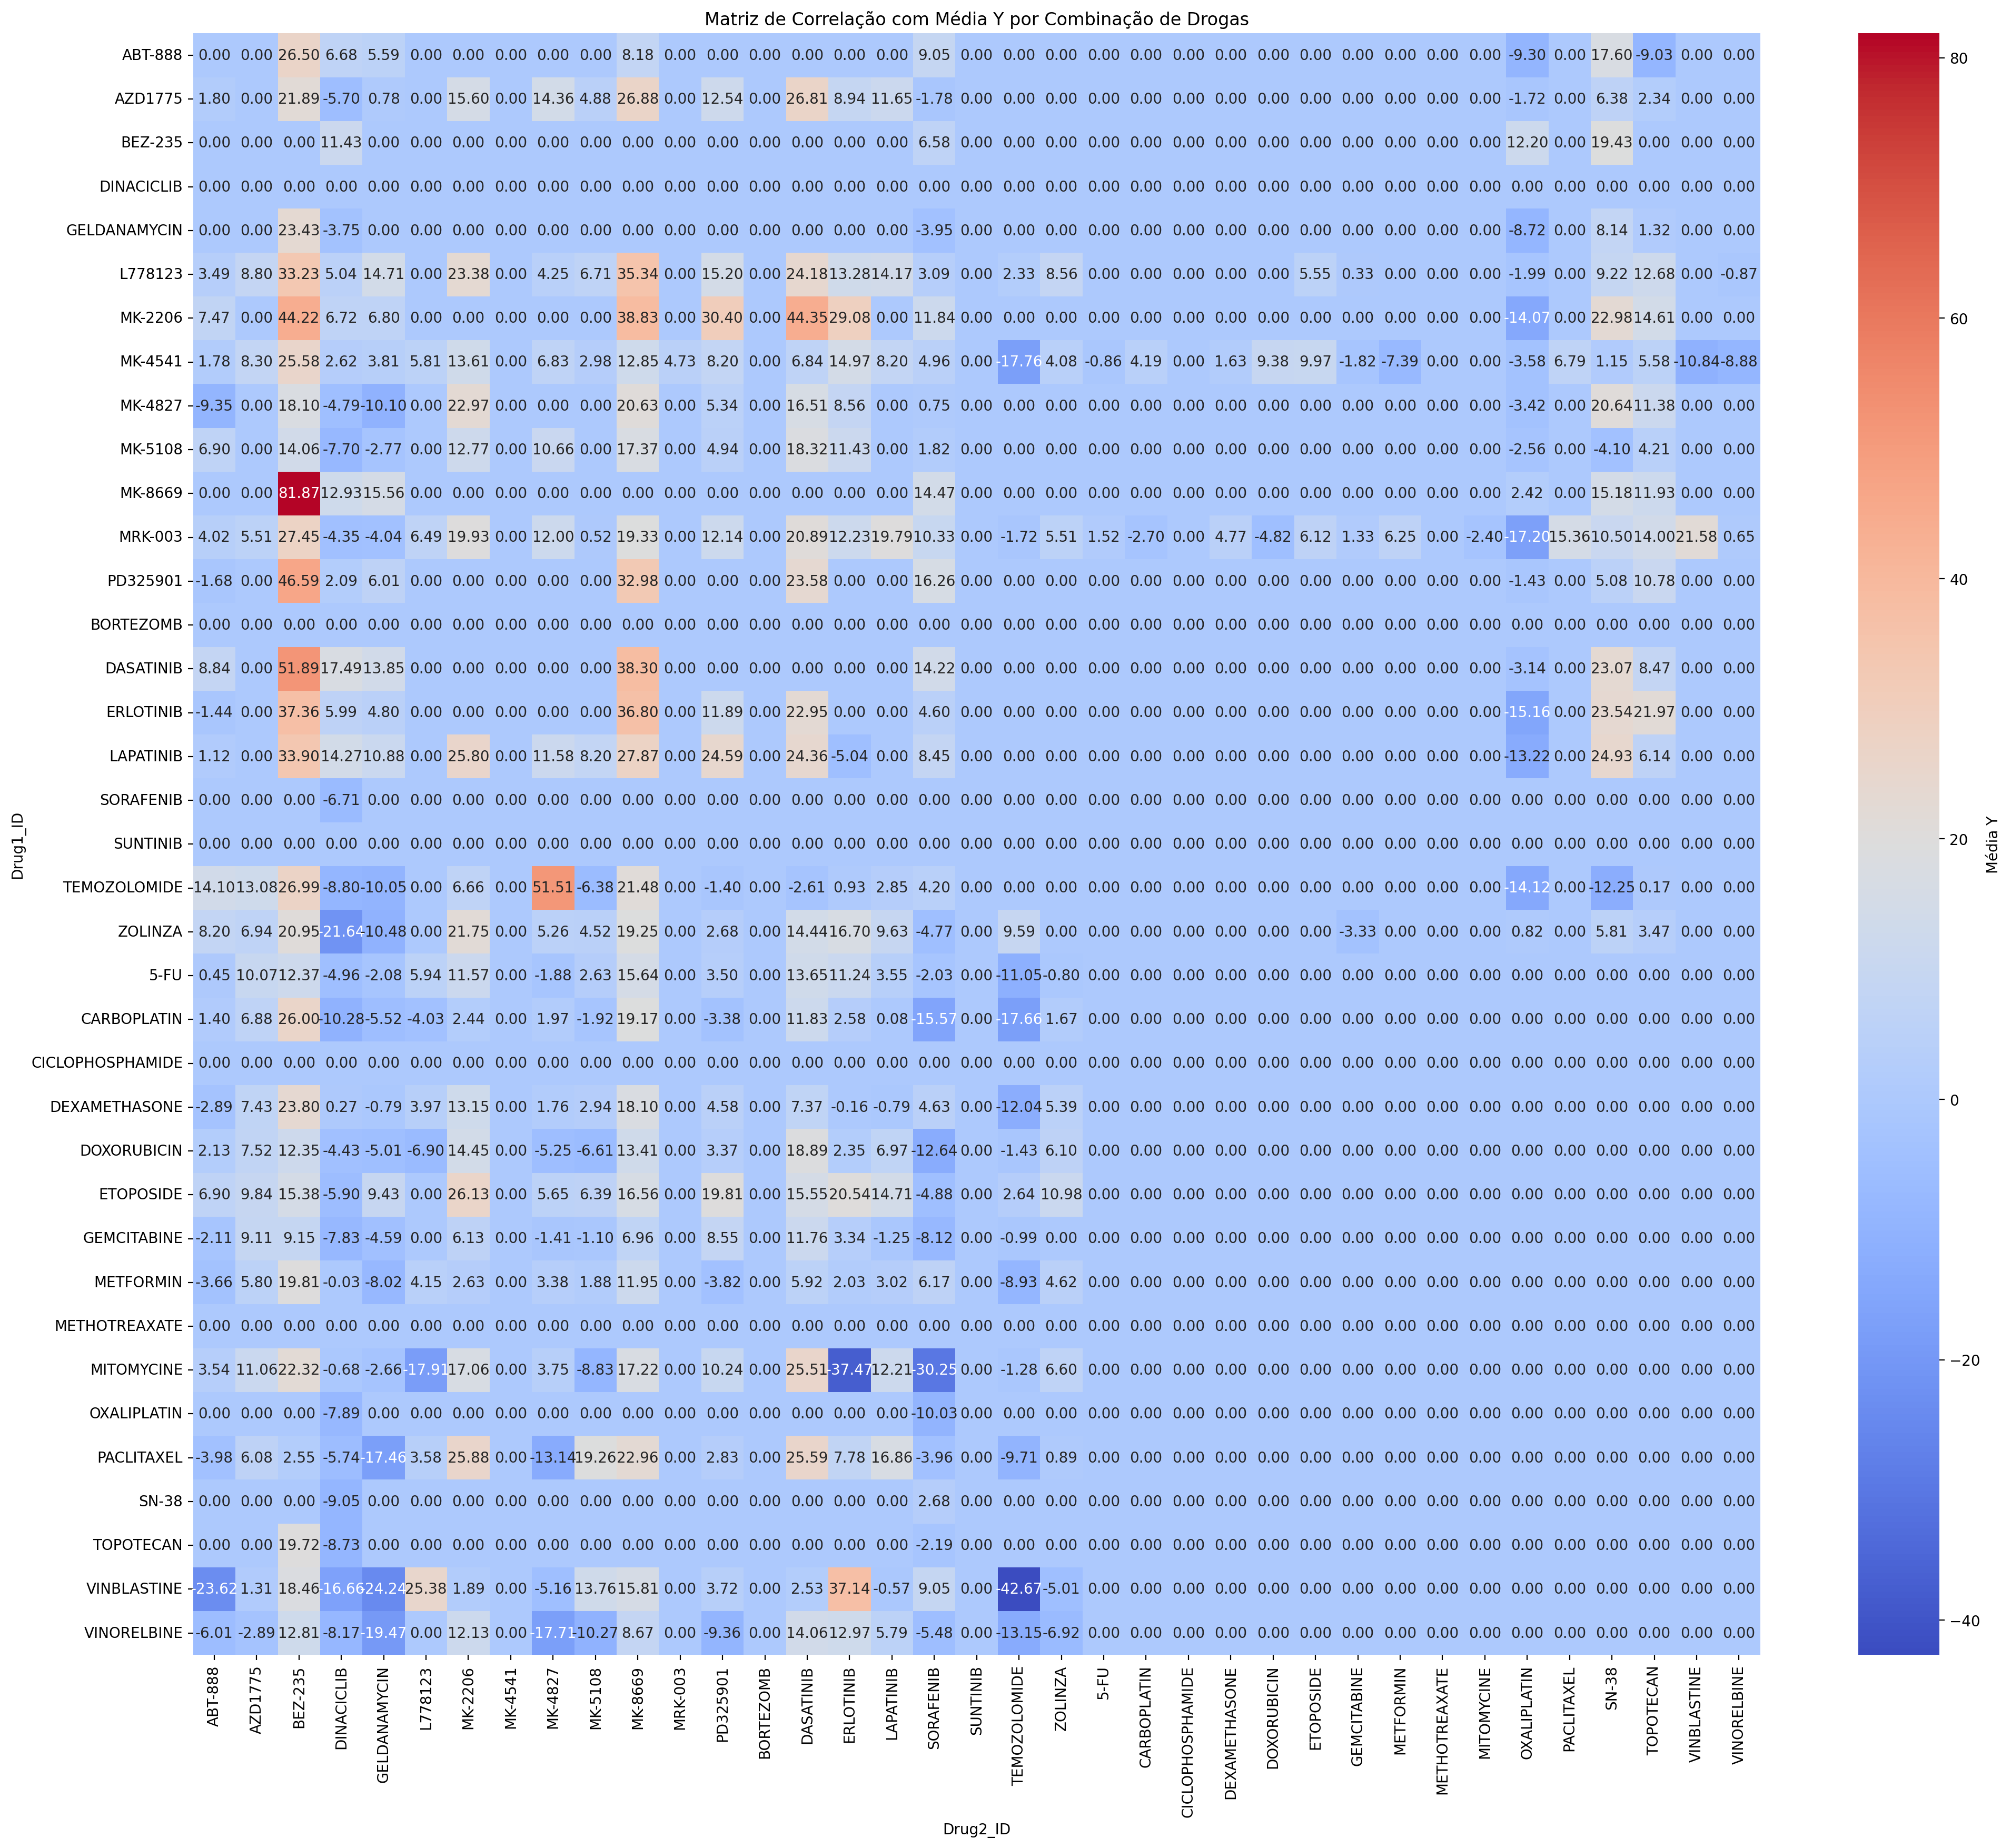

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
test=dataset
ordem_drogas = ["ABT-888","AZD1775","BEZ-235","DINACICLIB","GELDANAMYCIN","L778123","MK-2206","MK-4541", "MK-4827","MK-5108","MK-8669","MRK-003","PD325901","BORTEZOMB","DASATINIB","ERLOTINIB","LAPATINIB","SORAFENIB","SUNTINIB","TEMOZOLOMIDE","ZOLINZA","5-FU","CARBOPLATIN","CICLOPHOSPHAMIDE","DEXAMETHASONE","DOXORUBICIN","ETOPOSIDE","GEMCITABINE","METFORMIN","METHOTREAXATE","MITOMYCINE","OXALIPLATIN","PACLITAXEL","SN-38","TOPOTECAN","VINBLASTINE","VINORELBINE"]
test['Drug1_ID'] = pd.Categorical(test['Drug1_ID'], categories=ordem_drogas, ordered=True)
test['Drug2_ID'] = pd.Categorical(test['Drug2_ID'], categories=ordem_drogas, ordered=True)

# Calcular a média dos valores Y para cada combinação de drogas
media_por_combinacao = test.groupby(['Drug1_ID', 'Drug2_ID'])['Y'].mean().reset_index()

matriz_media = media_por_combinacao.pivot(index='Drug1_ID', columns='Drug2_ID', values='Y').fillna(0)
plt.figure(figsize=(24, 20), dpi=200)

sns.heatmap(matriz_media, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Média Y'},
            xticklabels=ordem_drogas, yticklabels=ordem_drogas)

plt.xlabel('Drug2_ID')
plt.ylabel('Drug1_ID')
plt.title('Matriz de Correlação com Média Y por Combinação de Drogas')

plt.show()

É possivel observar no canto inferior direito o conjunto de drogas que não foram combinadas estando os valores médios de y a zero.

Face a isso, o objetivo foi construir um dataset com apenas as 16 drogas referidas, seus respetivos smiles, descriotes, morgan fingerprint, maccscskeys. E no fim, retirar as linhas que continham valores NaN, bem como apenas considerar as colunas que tinham sido escolhidas no dataset utilizado para realizar o treino do smodelos de ML. 

In [3]:
from itertools import product

drogas_nao_combinadas = ["5-FU", "CARBOPLATIN", "CYCLOPHOSPHAMIDE", "DEXAMETHASONE", "DOXORUBICIN", "ETOPOSIDE",
                     "GEMCITABINE", "METFORMIN", "METHOTREXATE", "MITOMYCINE", "OXALIPLATIN", "PACLITAXEL",
                     "SN-38", "TOPOTECAN", "VINBLASTINE", "VINORELBINE"]

# Gerar todas as combinações de drogas a excluir
combinacoes_nao_existentes = list(product(drogas_nao_combinadas, drogas_nao_combinadas))

In [4]:
#retirar as combinações droga A-droga A porque nao faz sentido
filtered_list = [tupla for tupla in combinacoes_nao_existentes if tupla[0] != tupla[1]]

print(filtered_list)

[('5-FU', 'CARBOPLATIN'), ('5-FU', 'CYCLOPHOSPHAMIDE'), ('5-FU', 'DEXAMETHASONE'), ('5-FU', 'DOXORUBICIN'), ('5-FU', 'ETOPOSIDE'), ('5-FU', 'GEMCITABINE'), ('5-FU', 'METFORMIN'), ('5-FU', 'METHOTREXATE'), ('5-FU', 'MITOMYCINE'), ('5-FU', 'OXALIPLATIN'), ('5-FU', 'PACLITAXEL'), ('5-FU', 'SN-38'), ('5-FU', 'TOPOTECAN'), ('5-FU', 'VINBLASTINE'), ('5-FU', 'VINORELBINE'), ('CARBOPLATIN', '5-FU'), ('CARBOPLATIN', 'CYCLOPHOSPHAMIDE'), ('CARBOPLATIN', 'DEXAMETHASONE'), ('CARBOPLATIN', 'DOXORUBICIN'), ('CARBOPLATIN', 'ETOPOSIDE'), ('CARBOPLATIN', 'GEMCITABINE'), ('CARBOPLATIN', 'METFORMIN'), ('CARBOPLATIN', 'METHOTREXATE'), ('CARBOPLATIN', 'MITOMYCINE'), ('CARBOPLATIN', 'OXALIPLATIN'), ('CARBOPLATIN', 'PACLITAXEL'), ('CARBOPLATIN', 'SN-38'), ('CARBOPLATIN', 'TOPOTECAN'), ('CARBOPLATIN', 'VINBLASTINE'), ('CARBOPLATIN', 'VINORELBINE'), ('CYCLOPHOSPHAMIDE', '5-FU'), ('CYCLOPHOSPHAMIDE', 'CARBOPLATIN'), ('CYCLOPHOSPHAMIDE', 'DEXAMETHASONE'), ('CYCLOPHOSPHAMIDE', 'DOXORUBICIN'), ('CYCLOPHOSPHAMIDE',

In [5]:
drogas_unicas = list(OrderedDict.fromkeys(dataset['Drug1']))
print(drogas_unicas)

['O=c1[nH]cc(F)c(=O)[nH]1', 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'N.N.O=C(O)C1(C(=O)O)CCC1.[Pt]', 'O=P1(N(CCCl)CCCl)NCCCO1', 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1', 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1'

In [6]:
drogas = list(OrderedDict.fromkeys(dataset['Drug1_ID'])) #
print(drogas)

['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'BORTEZOMIB', 'CARBOPLATIN', 'CYCLOPHOSPHAMIDE', 'DASATINIB', 'DEXAMETHASONE', 'DINACICLIB', 'DOXORUBICIN', 'ERLOTINIB', 'ETOPOSIDE', 'GELDANAMYCIN', 'GEMCITABINE', 'L778123', 'LAPATINIB', 'METFORMIN', 'METHOTREXATE', 'MITOMYCINE', 'MK-2206', 'MK-4541', 'MK-4827', 'MK-5108', 'MK-8669', 'MRK-003', 'OXALIPLATIN', 'PACLITAXEL', 'PD325901', 'SN-38', 'SORAFENIB', 'SUNITINIB', 'TEMOZOLOMIDE', 'TOPOTECAN', 'VINBLASTINE', 'VINORELBINE', 'ZOLINZA']


In [7]:
mapeamento_drogas = dict(zip(drogas, drogas_unicas))
print(mapeamento_drogas)


{'5-FU': 'O=c1[nH]cc(F)c(=O)[nH]1', 'ABT-888': 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'AZD1775': 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'BEZ-235': 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'BORTEZOMIB': 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'CARBOPLATIN': 'N.N.O=C(O)C1(C(=O)O)CCC1.[Pt]', 'CYCLOPHOSPHAMIDE': 'O=P1(N(CCCl)CCCl)NCCCO1', 'DASATINIB': 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'DEXAMETHASONE': 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'DINACICLIB': 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'DOXORUBICIN': 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'ERLOTINIB': 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'ETOPOSIDE': 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'GELDANAMYCIN': 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'GEMCITABINE': 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1',

In [8]:
#dicionário que permite ter chave-valor, onde chave é o nome da droga e valor é o respetivo smile
dicionario_novo = {}

for drug, new_smiles in filtered_list:
    if drug in mapeamento_drogas:
        dicionario_novo[drug] = mapeamento_drogas[drug]
    
# Exibir o novo dicionário
print(dicionario_novo)



{'5-FU': 'O=c1[nH]cc(F)c(=O)[nH]1', 'CARBOPLATIN': 'N.N.O=C(O)C1(C(=O)O)CCC1.[Pt]', 'CYCLOPHOSPHAMIDE': 'O=P1(N(CCCl)CCCl)NCCCO1', 'DEXAMETHASONE': 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'DOXORUBICIN': 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'ETOPOSIDE': 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'GEMCITABINE': 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'METFORMIN': 'CN(C)C(=N)N=C(N)N', 'METHOTREXATE': 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1', 'MITOMYCINE': 'COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12', 'OXALIPLATIN': 'NC1CCCCC1N.O=C(O)C(=O)O.[Pt+2]', 'PACLITAXEL': 'CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(=O)c2ccccc2)C2(O)CC(OC(=O)C(O)C(NC(=O)c3ccccc3)c3ccccc3)C(C)=C1C2(C)C', 'SN-38': 'CCc1c2c(nc3ccc(O)cc13)-c1cc3c(c(=O)n1C2)COC(=O)C3(O)CC', 'TOPOTECAN': 'CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O)ccc3nc2-1', 'VINBLASTINE': 'CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3

In [9]:
print(len(dicionario_novo))

16


In [10]:
data = pd.DataFrame(filtered_list, columns=['Drug1_ID', 'Drug2_ID'])

# Exibir o DataFrame
print(data)

        Drug1_ID          Drug2_ID
0           5-FU       CARBOPLATIN
1           5-FU  CYCLOPHOSPHAMIDE
2           5-FU     DEXAMETHASONE
3           5-FU       DOXORUBICIN
4           5-FU         ETOPOSIDE
..           ...               ...
235  VINORELBINE       OXALIPLATIN
236  VINORELBINE        PACLITAXEL
237  VINORELBINE             SN-38
238  VINORELBINE         TOPOTECAN
239  VINORELBINE       VINBLASTINE

[240 rows x 2 columns]


In [11]:
data['Drug1'] = data["Drug1_ID"].map(dicionario_novo)
data['Drug2'] = data["Drug2_ID"].map(dicionario_novo)

# Exibir o DataFrame resultante
print(data)

        Drug1_ID          Drug2_ID  \
0           5-FU       CARBOPLATIN   
1           5-FU  CYCLOPHOSPHAMIDE   
2           5-FU     DEXAMETHASONE   
3           5-FU       DOXORUBICIN   
4           5-FU         ETOPOSIDE   
..           ...               ...   
235  VINORELBINE       OXALIPLATIN   
236  VINORELBINE        PACLITAXEL   
237  VINORELBINE             SN-38   
238  VINORELBINE         TOPOTECAN   
239  VINORELBINE       VINBLASTINE   

                                                 Drug1  \
0                              O=c1[nH]cc(F)c(=O)[nH]1   
1                              O=c1[nH]cc(F)c(=O)[nH]1   
2                              O=c1[nH]cc(F)c(=O)[nH]1   
3                              O=c1[nH]cc(F)c(=O)[nH]1   
4                              O=c1[nH]cc(F)c(=O)[nH]1   
..                                                 ...   
235  CCC1=CC2CN(C1)Cc1c([nH]c3ccccc13)C(C(=O)OC)(c1...   
236  CCC1=CC2CN(C1)Cc1c([nH]c3ccccc13)C(C(=O)OC)(c1...   
237  CCC1=CC2CN(C1)Cc

In [12]:
drogas_unicas = list(OrderedDict.fromkeys(data['Drug1'])) #drug 1 ou drug 2 têm as mesmas drogas mas em ordem diferente
len(drogas_unicas)

16

In [13]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria
RDLogger.DisableLog('rdApp.*') # disable rdkit warnings

def standardize(smiles):
    # convert to mol object
    mol = Chem.MolFromSmiles(smiles)

    # avoid errors with invalid molecules
    if mol is None:
        return None

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # convert back to smiles
    uncharged_parent_clean_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol)
    return uncharged_parent_clean_smiles

# apply the function to the SMILES column
resultados_stander=[]
for droga in drogas_unicas:
  resultado=standardize(droga)
  resultados_stander.append(resultado)
print(resultados_stander)

['O=c1[nH]cc(F)c(=O)[nH]1', 'O=C(O)C1(C(=O)O)CCC1', 'O=P1(N(CCCl)CCCl)NCCCO1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1', 'COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12', 'NC1CCCCC1N', 'CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(=O)c2ccccc2)C2(O)CC(OC(=O)C(O)C(NC(=O)c3ccccc3)c3ccccc3)C(C)=C1C2(C)C', 'CCc1c2c(nc3ccc(O)cc13)-c1cc3c(c(=O)n1C2)COC(=O)C3(O)CC', 'CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O)ccc3nc2-1', 'CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3cc4c(cc3OC)N(C)C3C(O)(C(=O)OC)C(OC(C)=O)C5(CC)C=CCN6CCC43C65)C2)C1', 'CCC1=CC2CN(C1)Cc1c([nH]c3ccccc13)C(C(=O)OC)(c1cc3c(cc1OC)N(C)C1C(O)(C(=O)OC)C(OC(C)=O)C4(CC)C=CCN5CCC31C54)C2']


In [14]:
# 2D descriptors
def get_descriptors(smiles):
    feature_names = [x[0] for x in Descriptors._descList]
    try:
        mol = Chem.MolFromSmiles(smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_names)
        # Deal with very large/inf values of the Ipc descriptor (https://github.com/rdkit/rdkit/issues/1527)
        # find position of Ipc
        pos = feature_names.index("Ipc")
        # calculate AvgIpc
        avg_ipc = Ipc(mol, avg=1)

        descriptors = list(calc.CalcDescriptors(mol))
        # replace Ipc with AvgIpc
        descriptors[pos] = avg_ipc
        descriptors = np.array(descriptors, dtype=np.float32)
        return descriptors
    except:
        # return np array of nans of size feature_names
        return np.empty(len(feature_names)) * np.nan


In [15]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria

# Morgan fingerprints

def get_morgan_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        morgan_fingerprints = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(morgan_fingerprints, np.float32)
    except:
        # return np array of nans of size feature_names
        return np.empty(1024) * np.nan

In [16]:
#MAACS smiles
def get_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    maccs_keys = MACCSkeys.GenMACCSKeys(mol)
    
    maccs_array = np.array(list(map(int, maccs_keys)))
    
    return maccs_array

In [17]:
dic={}
for droga in drogas_unicas:
  droga_padronizada=standardize(droga)
  descritores=get_descriptors(droga_padronizada)
  descritores=descritores.reshape(-1,1)
  scaler = StandardScaler()
  descritores_normalizados = scaler.fit_transform(descritores)
  descritores_final=descritores_normalizados.flatten()
  morgan=get_morgan_fingerprints(droga_padronizada)
  maccs=get_maccs(droga_padronizada)
  dic[droga]=(droga_padronizada,descritores_final,morgan,maccs)
#print(dic)

In [18]:
df = pd.DataFrame(dic.values(), columns=['Droga', 'Descritores',"morgan", "MACCSKey"])
df

Droga  \
0                             O=c1[nH]cc(F)c(=O)[nH]1   
1                                O=C(O)C1(C(=O)O)CCC1   
2                             O=P1(N(CCCl)CCCl)NCCCO1   
3   CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...   
4   COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=...   
5   COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3...   
6                   Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1   
7                                   CN(C)C(=N)N=C(N)N   
8   CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...   
9   COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12   
10                                         NC1CCCCC1N   
11  CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...   
12  CCc1c2c(nc3ccc(O)cc13)-c1cc3c(c(=O)n1C2)COC(=O...   
13  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...   
14  CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...   
15  CCC1=CC2CN(C1)Cc1c([nH]c3ccccc13)C(C(=O)OC)(c1...   

                                          Descritores  \
0   [0.21836044, -0.2581877, 0.21836044, -0.195501...   
1   [0.20747024, -0.33657113, 0.20747024, -0.25733...   
2   [0.089380845, -0.34087682, 0.089380845, -0.247...   
3   [-0.0017644739, -0.2577974, -0.0017644739, -0....   
4   [-0.09540144, -0.23157294, -0.09540144, -0.212...   
5   [-0.10435853, -0.22984017, -0.10435853, -0.217...   
6   [0.051568564, -0.31106454, 0.051568564, -0.231...   
7   [0.08660805, -0.2815891, 0.08660805, -0.274366...   
8   [-0.08853205, -0.22457536, -0.08853205, -0.211...   
9   [-0.034663707, -0.23986144, -0.034663707, -0.2...   
10  [0.0814198, -0.26740783, 0.0814198, -0.2674078...   
11  [-0.12408851, -0.21854587, -0.12408851, -0.205...   
12  [-0.059807386, -0.20982674, -0.059807386, -0.1...   
13  [-0.06802394, -0.21142785, -0.06802394, -0.192...   
14  [-0.11947167, -0.21497835, -0.11947167, -0.201...   
15  [-0.11588293, -0.2118207, -0.11588293, -0.1991...   

                                               morgan  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
10  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
11  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
13  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
15  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   

                                             MACCSKey  
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
11  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...  
12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
15  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [19]:
columns_to_map = ['Droga', 'Descritores',"morgan","MACCSKey"]
for column in columns_to_map:
    mapping_dict = dict(zip(df['Droga'], df[column]))
    data[column+'d1'] = data['Drug1'].map(mapping_dict)
    data[column+'d2'] = data['Drug2'].map(mapping_dict)


In [20]:
a1=data["Descritoresd1"].apply(pd.Series)
a1.columns=[f"drug1 {x[0]}" for x in Descriptors._descList]
data=pd.concat([data,a1], axis=1)
data=data.drop("Descritoresd1", axis=1)
# dataset

In [21]:
b1=data["morgand1"].apply(pd.Series)
b1.columns=[f"morgan drug1 {i}" for i in range(b1.shape[1])]
data=pd.concat([data,b1], axis=1)
data=data.drop("morgand1", axis=1)

In [22]:
c1=data["MACCSKeyd1"].apply(pd.Series)
c1.columns=[f"MACCSKey drug1 {i}" for i in range(c1.shape[1])]
data=pd.concat([data,c1], axis=1)
data=data.drop("MACCSKeyd1", axis=1)

In [23]:
a2=data["Descritoresd2"].apply(pd.Series)
a2.columns=[f"drug2 {x[0]}" for x in Descriptors._descList]
data=pd.concat([data,a2], axis=1)
data=data.drop("Descritoresd2", axis=1)

In [24]:
b2=data["morgand2"].apply(pd.Series)
b2.columns=[f"morgan drug2 {i}" for i in range(b2.shape[1])]
data=pd.concat([data,b2], axis=1)
data=data.drop("morgand2", axis=1)

In [25]:
c2=data["MACCSKeyd2"].apply(pd.Series)
c2.columns=[f"MACCSKey drug2 {i}" for i in range(c2.shape[1])]
data=pd.concat([data,c2], axis=1)
data=data.drop("MACCSKeyd2", axis=1)

In [28]:
colunas_a_remover = [0,1,2,3,4,5]

data = data.drop(data.columns[colunas_a_remover], axis=1)

data

drug1 MaxEStateIndex  drug1 MinEStateIndex  drug1 MaxAbsEStateIndex  \
0                0.218360             -0.258188                 0.218360   
1                0.218360             -0.258188                 0.218360   
2                0.218360             -0.258188                 0.218360   
3                0.218360             -0.258188                 0.218360   
4                0.218360             -0.258188                 0.218360   
..                    ...                   ...                      ...   
235             -0.115883             -0.211821                -0.115883   
236             -0.115883             -0.211821                -0.115883   
237             -0.115883             -0.211821                -0.115883   
238             -0.115883             -0.211821                -0.115883   
239             -0.115883             -0.211821                -0.115883   

     drug1 MinAbsEStateIndex  drug1 qed  drug1 MolWt  drug1 HeavyAtomMolWt  \
0                  -0.195502  -0.203739     4.552044              4.441072   
1                  -0.195502  -0.203739     4.552044              4.441072   
2                  -0.195502  -0.203739     4.552044              4.441072   
3                  -0.195502  -0.203739     4.552044              4.441072   
4                  -0.195502  -0.203739     4.552044              4.441072   
..                       ...        ...          ...                   ...   
235                -0.199157  -0.198237     4.084161              3.784837   
236                -0.199157  -0.198237     4.084161              3.784837   
237                -0.199157  -0.198237     4.084161              3.784837   
238                -0.199157  -0.198237     4.084161              3.784837   
239                -0.199157  -0.198237     4.084161              3.784837   

     drug1 ExactMolWt  drug1 NumValenceElectrons  drug1 NumRadicalElectrons  \
0            4.549836                   1.540015                  -0.221448   
1            4.549836                   1.540015                  -0.221448   
2            4.549836                   1.540015                  -0.221448   
3            4.549836                   1.540015                  -0.221448   
4            4.549836                   1.540015                  -0.221448   
..                ...                        ...                        ...   
235          4.081121                   1.461402                  -0.199313   
236          4.081121                   1.461402                  -0.199313   
237          4.081121                   1.461402                  -0.199313   
238          4.081121                   1.461402                  -0.199313   
239          4.081121                   1.461402                  -0.199313   

     ...  MACCSKey drug2 157  MACCSKey drug2 158  MACCSKey drug2 159  \
0    ...                 NaN                 NaN                 NaN   
1    ...                 1.0                 1.0                 1.0   
2    ...                 1.0                 0.0                 1.0   
3    ...                 1.0                 1.0                 1.0   
4    ...                 1.0                 0.0                 1.0   
..   ...                 ...                 ...                 ...   
235  ...                 NaN                 NaN                 NaN   
236  ...                 1.0                 1.0                 1.0   
237  ...                 1.0                 1.0                 1.0   
238  ...                 1.0                 1.0                 1.0   
239  ...                 1.0                 1.0                 1.0   

     MACCSKey drug2 160  MACCSKey drug2 161  MACCSKey drug2 162  \
0                   NaN                 NaN                 NaN   
1                   0.0                 1.0                 0.0   
2                   1.0                 0.0                 0.0   
3                   1.0                 1.0                 1.0   
4     

In [29]:
data = data.dropna()
data

drug1 MaxEStateIndex  drug1 MinEStateIndex  drug1 MaxAbsEStateIndex  \
1                0.218360             -0.258188                 0.218360   
2                0.218360             -0.258188                 0.218360   
3                0.218360             -0.258188                 0.218360   
4                0.218360             -0.258188                 0.218360   
5                0.218360             -0.258188                 0.218360   
..                    ...                   ...                      ...   
234             -0.115883             -0.211821                -0.115883   
236             -0.115883             -0.211821                -0.115883   
237             -0.115883             -0.211821                -0.115883   
238             -0.115883             -0.211821                -0.115883   
239             -0.115883             -0.211821                -0.115883   

     drug1 MinAbsEStateIndex  drug1 qed  drug1 MolWt  drug1 HeavyAtomMolWt  \
1                  -0.195502  -0.203739     4.552044              4.441072   
2                  -0.195502  -0.203739     4.552044              4.441072   
3                  -0.195502  -0.203739     4.552044              4.441072   
4                  -0.195502  -0.203739     4.552044              4.441072   
5                  -0.195502  -0.203739     4.552044              4.441072   
..                       ...        ...          ...                   ...   
234                -0.199157  -0.198237     4.084161              3.784837   
236                -0.199157  -0.198237     4.084161              3.784837   
237                -0.199157  -0.198237     4.084161              3.784837   
238                -0.199157  -0.198237     4.084161              3.784837   
239                -0.199157  -0.198237     4.084161              3.784837   

     drug1 ExactMolWt  drug1 NumValenceElectrons  drug1 NumRadicalElectrons  \
1            4.549836                   1.540015                  -0.221448   
2            4.549836                   1.540015                  -0.221448   
3            4.549836                   1.540015                  -0.221448   
4            4.549836                   1.540015                  -0.221448   
5            4.549836                   1.540015                  -0.221448   
..                ...                        ...                        ...   
234          4.081121                   1.461402                  -0.199313   
236          4.081121                   1.461402                  -0.199313   
237          4.081121                   1.461402                  -0.199313   
238          4.081121                   1.461402                  -0.199313   
239          4.081121                   1.461402                  -0.199313   

     ...  MACCSKey drug2 157  MACCSKey drug2 158  MACCSKey drug2 159  \
1    ...                 1.0                 1.0                 1.0   
2    ...                 1.0                 0.0                 1.0   
3    ...                 1.0                 1.0                 1.0   
4    ...                 1.0                 0.0                 1.0   
5    ...                 1.0                 1.0                 1.0   
..   ...                 ...                 ...                 ...   
234  ...                 1.0                 1.0                 1.0   
236  ...                 1.0                 1.0                 1.0   
237  ...                 1.0                 1.0                 1.0   
238  ...                 1.0                 1.0                 1.0   
239  ...                 1.0                 1.0                 1.0   

     MACCSKey drug2 160  MACCSKey drug2 161  MACCSKey drug2 162  \
1                   0.0                 1.0                 0.0   
2                   1.0                 0.0                 0.0   
3                   1.0                 1.0                 1.0   
4                   1.0                 0.0                 1.0   
5     

In [30]:
path="C:\\Users\\guilh\\OneDrive - Universidade de Aveiro\\Guilherme\\dataset.csv"
dataset_filtrado_previo=pd.read_csv(path)

Ponto chave, onde é apenas considerado as features em comum entre o dataset (data) , trabalhado até agora, e o dataset que foi utiizado na parte 3 do trabalho (ML).

In [31]:
colunas_comuns=dataset_filtrado_previo.columns.intersection(data.columns)
data=data[colunas_comuns]
data

drug1 MolWt  drug1 HeavyAtomMolWt  drug1 ExactMolWt  \
1       4.552044              4.441072          4.549836   
2       4.552044              4.441072          4.549836   
3       4.552044              4.441072          4.549836   
4       4.552044              4.441072          4.549836   
5       4.552044              4.441072          4.549836   
..           ...                   ...               ...   
234     4.084161              3.784837          4.081121   
236     4.084161              3.784837          4.081121   
237     4.084161              3.784837          4.081121   
238     4.084161              3.784837          4.081121   
239     4.084161              3.784837          4.081121   

     drug1 NumValenceElectrons  drug1 BCUT2D_MWHI  drug1 BertzCT  \
1                     1.540015           0.481017      11.258666   
2                     1.540015           0.481017      11.258666   
3                     1.540015           0.481017      11.258666   
4                     1.540015           0.481017      11.258666   
5                     1.540015           0.481017      11.258666   
..                         ...                ...            ...   
234                   1.461402          -0.108156      12.162404   
236                   1.461402          -0.108156      12.162404   
237                   1.461402          -0.108156      12.162404   
238                   1.461402          -0.108156      12.162404   
239                   1.461402          -0.108156      12.162404   

     drug1 LabuteASA  drug1 PEOE_VSA7  drug1 SMR_VSA5  drug1 SMR_VSA7  ...  \
1           1.553200        -0.221448       -0.221448        0.984132  ...   
2           1.553200        -0.221448       -0.221448        0.984132  ...   
3           1.553200        -0.221448       -0.221448        0.984132  ...   
4           1.553200        -0.221448       -0.221448        0.984132  ...   
5           1.553200        -0.221448       -0.221448        0.984132  ...   
..               ...              ...             ...             ...  ...   
234         1.633472         0.138360        0.282503        0.254819  ...   
236         1.633472         0.138360        0.282503        0.254819  ...   
237         1.633472         0.138360        0.282503        0.254819  ...   
238         1.633472         0.138360        0.282503        0.254819  ...   
239         1.633472         0.138360        0.282503        0.254819  ...   

     MACCSKey drug2 149  MACCSKey drug2 150  MACCSKey drug2 151  \
1                   0.0                 0.0                 1.0   
2                   1.0                 1.0                 0.0   
3                   1.0                 1.0                 1.0   
4                   1.0                 1.0                 0.0   
5                   0.0                 1.0                 1.0   
..                  ...                 ...                 ...   
234                 1.0                 1.0                 1.0   
236                 1.0                 1.0                 1.0   
237                 1.0                 1.0                 0.0   
238                 1.0                 1.0                 0.0   
239                 1.0                 1.0                 1.0   

     MACCSKey drug2 152  MACCSKey drug2 153  MACCSKey drug2 154  \
1                   0.0                 1.0                 0.0   
2                   1.0                 1.0                 1.0   
3                   1.0                 1.0                 1.0   
4                   1.0                 1.0                 1.0   
5                   1.0                 1.0                 1.0   
..                  ...                 ...                 ...   
234                 1.0                 1.0                 1.0   
236                 1.0                 1.0                 1.0   
237                 1.0                 1.0                 1.0   
238                 1.0                 1.0            

In [48]:
df_filtered = dataset[dataset['Drug1_ID'].isin(['5-FU']) & dataset['Drug2_ID'].isin(['ABT-888']) & (dataset['Cell_Line_ID'] == 'A2058')]
df_filtered


Drug1_ID Drug2_ID Cell_Line_ID        Y  \
0     5-FU  ABT-888        A2058  7.69353   

                                           Cell_Line                    Drug1  \
0  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   

                                Drug2  
0  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1

In [52]:
df_filtered = dataset[dataset['Drug1_ID'].isin(['5-FU']) & dataset['Drug2_ID'].isin(['SN-38']) & (dataset['Cell_Line_ID'] == 'A2058')]
df_filtered

Empty DataFrame
Columns: [Drug1_ID, Drug2_ID, Cell_Line_ID, Y, Cell_Line, Drug1, Drug2]
Index: []

Conclusão

Como é possível verificar há combinações que simplemente nao têm info, confirmando que as drogas em questão nem foram combinadas.

O datatset, com a designação data criado, já contem a info necessária em termos de descritores, morganfingerprints e maccskeys para realizar a previsão.

Todavia, é ainda necessário realizar a parte bio no sentido de obter os valores face às respetivas cell lines. Apenas depois de completar esse aspeto ficariamos com um dataset capaz de ser "introduzido" no melhor modelo de ML obtido, RF, e prever um valor de y .

Trabalho Futuro

Após obter os respetivos valores das cell lines seria interessante criar uma plataforma que permitisse ao utilizador face ao melhor modelo já referido, prever os valores de y para uma determinada cell line. Sabemos que seria algo ambicioso, contudo não muito complicado de realizar uma vez que já temos a parte dos compostos realizada e já sabemos quais os "parametros das cell lines iriamos utilizar. Levando a que o desenvolvimento da tal plataforma fosse, nesta altura, o real desafio. 